In [506]:
#!pip install yfinance
#!pip install pandas-ta

In [507]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

import yfinance as yf



In [508]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# GET THE TRADING DATA

In [509]:
#SPX500 data

df_analisys = yf.download('^GSPC',period="30d", interval="15m")
#df_analisys = yf.download('^GSPC', interval="5m", start="2022-02-16", end="2022-03-03")

df_analisys = df_analisys.reset_index()

print(df_analisys.shape)
df_analisys

[*********************100%***********************]  1 of 1 completed
(771, 7)


,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-01-25 09:30:00-05:00,4366.640137,4366.640137,4334.669922,4337.319824,4337.319824,108392971
1,2022-01-25 09:45:00-05:00,4337.229980,4337.229980,4299.529785,4304.509766,4304.509766,138840281
2,2022-01-25 10:00:00-05:00,4305.919922,4312.720215,4287.109863,4310.790039,4310.790039,118896967
3,2022-01-25 10:15:00-05:00,4311.529785,4337.419922,4305.700195,4337.419922,4337.419922,107561501
4,2022-01-25 10:30:00-05:00,4338.089844,4341.939941,4319.390137,4341.850098,4341.850098,103533391
...,...,...,...,...,...,...,...
766,2022-03-08 12:30:00-05:00,4243.419922,4257.319824,4236.089844,4255.589844,4255.589844,136619000
767,2022-03-08 12:45:00-05:00,4255.430176,4260.669922,4244.479980,4257.279785,4257.279785,108592000
768,2022-03-08 13:00:00-05:00,4257.229980,4276.939941,4257.229980,4268.799805,4268.799805,107266000
769,2022-03-08 13:15:00-05:00,4268.390137,4271.000000,4268.390137,4269.430176,4269.430176,5589000


In [510]:
df_analisys.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [511]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys.to_pickle(DIR_OUTPUTS + 'df_spx500_15m_raw' + '.pkl')
print(df_analisys.shape)

(771, 7)


In [512]:
#df_analisys[ (df_analisys['Datetime']>=dt.datetime(2022,3,3,15,30))]

# Candles computations

In [513]:
#Fixes the trading date
df_analisys['Datetime'] = df_analisys['Datetime'].dt.tz_localize(None)
df_analisys['Datetime']

0     2022-01-25 09:30:00
1     2022-01-25 09:45:00
2     2022-01-25 10:00:00
3     2022-01-25 10:15:00
4     2022-01-25 10:30:00
              ...        
766   2022-03-08 12:30:00
767   2022-03-08 12:45:00
768   2022-03-08 13:00:00
769   2022-03-08 13:15:00
770   2022-03-08 13:16:20
Name: Datetime, Length: 771, dtype: datetime64[ns]

In [514]:
df_analisys['date'] = df_analisys['Datetime'].apply(lambda x: x.date())
df_analisys['date']

0      2022-01-25
1      2022-01-25
2      2022-01-25
3      2022-01-25
4      2022-01-25
          ...    
766    2022-03-08
767    2022-03-08
768    2022-03-08
769    2022-03-08
770    2022-03-08
Name: date, Length: 771, dtype: object

In [515]:
#Computes body sizes

df_analisys['body_size'] = df_analisys['Close'] - df_analisys['Open']
df_analisys['abs_body_size'] = abs(df_analisys['body_size'])
df_analisys['upper_tail_size'] = df_analisys['High'] - df_analisys[['Open','Close']].max(axis=1)
df_analisys['lower_tail_size'] = df_analisys[['Open','Close']].min(axis=1) - df_analisys['Low']

df_analisys[0:50]

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size
0,2022-01-25 09:30:00,4366.640137,4366.640137,4334.669922,4337.319824,4337.319824,108392971,2022-01-25,-29.320312,29.320312,0.000000,2.649902
1,2022-01-25 09:45:00,4337.229980,4337.229980,4299.529785,4304.509766,4304.509766,138840281,2022-01-25,-32.720215,32.720215,0.000000,4.979980
2,2022-01-25 10:00:00,4305.919922,4312.720215,4287.109863,4310.790039,4310.790039,118896967,2022-01-25,4.870117,4.870117,1.930176,18.810059
3,2022-01-25 10:15:00,4311.529785,4337.419922,4305.700195,4337.419922,4337.419922,107561501,2022-01-25,25.890137,25.890137,0.000000,5.829590
4,2022-01-25 10:30:00,4338.089844,4341.939941,4319.390137,4341.850098,4341.850098,103533391,2022-01-25,3.760254,3.760254,0.089844,18.699707
5,2022-01-25 10:45:00,4343.240234,4353.120117,4323.660156,4325.319824,4325.319824,99688508,2022-01-25,-17.920410,17.920410,9.879883,1.659668
6,2022-01-25 11:00:00,4325.419922,4334.859863,4314.680176,4316.259766,4316.259766,84075384,2022-01-25,-9.160156,9.160156,9.439941,1.579590
7,2022-01-25 11:15:00,4316.290039,4342.810059,4313.609863,4335.720215,4335.720215,86186449,2022-01-25,19.430176,19.430176,7.089844,2.680176
8,2022-01-25 11:30:00,4335.709961,4336.669922,4307.060059,4316.549805,4316.549805,80641214,2022-01-25,-19.160156,19.160156,0.959961,9.489746
9,2022-01-25 11:45:00,4316.419922,4331.439941,4311.990234,4312.290039,4312.290039,75043000,2022-01-25,-4.129883,4.129883,15.020020,0.299805


In [516]:
#Computes candles color
df_analisys['body_disposal']=None
df_analisys.loc[df_analisys['body_size']>0,'body_disposal'] = 1
df_analisys.loc[df_analisys['body_size']<0,'body_disposal'] = 0

print(df_analisys['body_disposal'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))




   index  body_disposal
1    0.0            380
0    1.0            390
2    NaN              1


# Target signal

In [517]:
#Computes Target signal

nro_rows = len(df_analisys)
for i in range(0,nro_rows):
    
    profit_threshold = 20
    
    try:
        #Searches for the after indexes where the profit threshold is fullfilled 
        s_threshold = ((df_analisys['Close'][i] - df_analisys['Close'].iloc[i+1:]).abs() > profit_threshold)
        idxs = s_threshold[s_threshold].index
        
        try:
            target_idx = [min(idxs)]
        except:
            target_idx = []
        
        df_data = df_analisys.iloc[target_idx]

        Datetime = df_analisys['Datetime'][i]

        keepcols = ['Datetime','Close']
        df_data = df_data[keepcols]

        dic_rencols = {
            'Datetime':'target_date',
            'Close': 'target_close',
        }

        df_data = df_data.rename(columns=dic_rencols)
        df_data['Datetime'] = Datetime

        if i == 0:
            df_target =df_data.copy()
        else:
            df_target =df_target.append(df_data).copy()
            
    except:
        pass
        
df_target = df_target.reset_index(drop=True)
df_target

,target_date,target_close,Datetime
0,2022-01-25 09:45:00,4304.509766,2022-01-25 09:30:00
1,2022-01-25 10:15:00,4337.419922,2022-01-25 09:45:00
2,2022-01-25 10:15:00,4337.419922,2022-01-25 10:00:00
3,2022-01-25 11:00:00,4316.259766,2022-01-25 10:15:00
4,2022-01-25 11:00:00,4316.259766,2022-01-25 10:30:00
...,...,...,...
761,2022-03-08 12:00:00,4234.350098,2022-03-08 11:15:00
762,2022-03-08 12:00:00,4234.350098,2022-03-08 11:30:00
763,2022-03-08 12:00:00,4234.350098,2022-03-08 11:45:00
764,2022-03-08 12:30:00,4255.589844,2022-03-08 12:00:00


In [518]:
df_analisys_01 = pd.merge(df_analisys,
                         df_target,
                         on = ['Datetime'],
                         how = 'left').copy()

#Computes the target difference in closure prices
df_analisys_01['target_difference'] =  round( df_analisys_01['target_close'] - df_analisys_01['Close'] )

print(df_analisys.shape)
print(df_analisys_01.shape)

print(df_analisys_01['target_difference'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))

df_analisys_01

(771, 13)
(771, 16)
    index  target_difference
50 -108.0                  2
72 -104.0                  1
64  -99.0                  1
65  -94.0                  1
63  -90.0                  1
..    ...                ...
48   70.0                  2
58   71.0                  2
76   73.0                  1
78   83.0                  1
33    NaN                  5

[86 rows x 2 columns]


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference
0,2022-01-25 09:30:00,4366.640137,4366.640137,4334.669922,4337.319824,4337.319824,108392971,2022-01-25,-29.320312,29.320312,0.000000,2.649902,0,2022-01-25 09:45:00,4304.509766,-33.0
1,2022-01-25 09:45:00,4337.229980,4337.229980,4299.529785,4304.509766,4304.509766,138840281,2022-01-25,-32.720215,32.720215,0.000000,4.979980,0,2022-01-25 10:15:00,4337.419922,33.0
2,2022-01-25 10:00:00,4305.919922,4312.720215,4287.109863,4310.790039,4310.790039,118896967,2022-01-25,4.870117,4.870117,1.930176,18.810059,1,2022-01-25 10:15:00,4337.419922,27.0
3,2022-01-25 10:15:00,4311.529785,4337.419922,4305.700195,4337.419922,4337.419922,107561501,2022-01-25,25.890137,25.890137,0.000000,5.829590,1,2022-01-25 11:00:00,4316.259766,-21.0
4,2022-01-25 10:30:00,4338.089844,4341.939941,4319.390137,4341.850098,4341.850098,103533391,2022-01-25,3.760254,3.760254,0.089844,18.699707,1,2022-01-25 11:00:00,4316.259766,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,2022-03-08 12:30:00,4243.419922,4257.319824,4236.089844,4255.589844,4255.589844,136619000,2022-03-08,12.169922,12.169922,1.729980,7.330078,1,NaT,NaN,NaN
767,2022-03-08 12:45:00,4255.430176,4260.669922,4244.479980,4257.279785,4257.279785,108592000,2022-03-08,1.849609,1.849609,3.390137,10.950195,1,NaT,NaN,NaN
768,2022-03-08 13:00:00,4257.229980,4276.939941,4257.229980,4268.799805,4268.799805,107266000,2022-03-08,11.569824,11.569824,8.140137,0.000000,1,NaT,NaN,NaN
769,2022-03-08 13:15:00,4268.390137,4271.000000,4268.390137,4269.430176,4269.430176,5589000,2022-03-08,1.040039,1.040039,1.569824,0.000000,1,NaT,NaN,NaN


In [519]:
df_varbins = df_analisys_01[['target_difference']]
df_varbins['target_bins'] = pd.qcut(df_varbins['target_difference'], 20, duplicates='drop')
df_varbins['target_bins'] = df_varbins['target_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_bins'].astype(str)

print(df_varbins['target_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                   index  target_bins
20                00-nan            5
8   01-(-108.001, -40.0]           40
6      02-(-40.0, -34.0]           41
7      03-(-34.0, -30.0]           41
9      04-(-30.0, -28.0]           39
1      05-(-28.0, -26.0]           54
16     06-(-26.0, -25.0]           28
17     07-(-25.0, -24.0]           27
5      08-(-24.0, -23.0]           42
3      09-(-23.0, -22.0]           51
2      10-(-22.0, -21.0]           52
18     11-(-21.0, -20.0]           25
15      12-(-20.0, 20.0]           30
12       13-(20.0, 21.0]           34
0        14-(21.0, 23.0]           55
19       15-(23.0, 24.0]           24
4        16-(24.0, 26.0]           43
13       17-(26.0, 28.0]           34
11       18-(28.0, 32.0]           36
14       19-(32.0, 40.0]           32
10       20-(40.0, 83.0]           38


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [520]:
#Computes the target difference in transcurred time
df_analisys_01['target_date_diff'] =  df_analisys_01['target_date'] - df_analisys_01['Datetime']
df_analisys_01['target_date_diff'] = df_analisys_01['target_date_diff'] / np.timedelta64(1,'m')

df_analisys_01

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference,target_date_diff
0,2022-01-25 09:30:00,4366.640137,4366.640137,4334.669922,4337.319824,4337.319824,108392971,2022-01-25,-29.320312,29.320312,0.000000,2.649902,0,2022-01-25 09:45:00,4304.509766,-33.0,15.0
1,2022-01-25 09:45:00,4337.229980,4337.229980,4299.529785,4304.509766,4304.509766,138840281,2022-01-25,-32.720215,32.720215,0.000000,4.979980,0,2022-01-25 10:15:00,4337.419922,33.0,30.0
2,2022-01-25 10:00:00,4305.919922,4312.720215,4287.109863,4310.790039,4310.790039,118896967,2022-01-25,4.870117,4.870117,1.930176,18.810059,1,2022-01-25 10:15:00,4337.419922,27.0,15.0
3,2022-01-25 10:15:00,4311.529785,4337.419922,4305.700195,4337.419922,4337.419922,107561501,2022-01-25,25.890137,25.890137,0.000000,5.829590,1,2022-01-25 11:00:00,4316.259766,-21.0,45.0
4,2022-01-25 10:30:00,4338.089844,4341.939941,4319.390137,4341.850098,4341.850098,103533391,2022-01-25,3.760254,3.760254,0.089844,18.699707,1,2022-01-25 11:00:00,4316.259766,-26.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,2022-03-08 12:30:00,4243.419922,4257.319824,4236.089844,4255.589844,4255.589844,136619000,2022-03-08,12.169922,12.169922,1.729980,7.330078,1,NaT,NaN,NaN,NaN
767,2022-03-08 12:45:00,4255.430176,4260.669922,4244.479980,4257.279785,4257.279785,108592000,2022-03-08,1.849609,1.849609,3.390137,10.950195,1,NaT,NaN,NaN,NaN
768,2022-03-08 13:00:00,4257.229980,4276.939941,4257.229980,4268.799805,4268.799805,107266000,2022-03-08,11.569824,11.569824,8.140137,0.000000,1,NaT,NaN,NaN,NaN
769,2022-03-08 13:15:00,4268.390137,4271.000000,4268.390137,4269.430176,4269.430176,5589000,2022-03-08,1.040039,1.040039,1.569824,0.000000,1,NaT,NaN,NaN,NaN


In [521]:
df_varbins = df_analisys_01[['target_date_diff']]
df_varbins['target_date_bins'] = pd.qcut(df_varbins['target_date_diff'], 20, duplicates='drop')
df_varbins['target_date_bins'] = df_varbins['target_date_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_date_bins'].astype(str)

print(df_varbins['target_date_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                   index  target_date_bins
16                00-nan                 5
0      01-(14.999, 30.0]               138
1        02-(30.0, 45.0]                72
2        03-(45.0, 60.0]                70
3        04-(60.0, 75.0]                53
4        05-(75.0, 90.0]                43
12      06-(90.0, 105.0]                34
14     07-(105.0, 120.0]                31
15     08-(120.0, 135.0]                22
9      09-(135.0, 165.0]                38
11     10-(165.0, 270.0]                37
6     11-(270.0, 1080.0]                40
5    12-(1080.0, 1125.0]                42
13  13-(1125.0, 1173.75]                31
7   14-(1173.75, 1260.0]                39
10  15-(1260.0, 1638.75]                37
8   16-(1638.75, 5460.0]                39


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [522]:
# Computes high time to produce additional categories fo the target

df_varbins = df_varbins.sort_values(['target_date_diff'])
df_varbins = df_varbins[df_varbins.notna().all(axis=1)]
size = round(len(df_varbins)*(0.5))

high_time = df_varbins.iloc[size,:]['target_date_diff']
high_time

105.0

In [523]:
mean_time = df_varbins['target_date_diff'].mode()
print('Mean awaiting time to profit: ', mean_time)

Mean awaiting time to profit:  0    30.0
dtype: float64


In [524]:
#computes the target order movement
df_analisys_01['target_order'] = 'NULL'

df_analisys_01.loc[df_analisys_01['target_difference'] < 0, 'target_order'] = 'SELL'

df_analisys_01.loc[(df_analisys_01['target_difference'] < 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'SELL2'


df_analisys_01.loc[df_analisys_01['target_difference'] > 0, 'target_order'] = 'BUY'

df_analisys_01.loc[(df_analisys_01['target_difference'] > 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'BUY2'


df_analisys_01.loc[abs(df_analisys_01['target_difference']) < profit_threshold, 'target_order'] = 'NULL'

df_analisys_01['target_order_bin'] = 0
df_analisys_01.loc[df_analisys_01['target_order'] == 'BUY', 'target_order_bin'] = 1

print(df_analisys_01['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))
print(df_analisys_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
2    BUY           196
3   BUY2           130
4   NULL             5
1   SELL           214
0  SELL2           226
   index  target_order_bin
0      0               575
1      1               196


# MACD and EMA indicators

In [525]:
# # Calculate MACD values using the pandas_ta library
df_macd = df_analisys_01.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
df_macd


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
766,-6.648570,10.113574,-16.762144
767,-2.473068,11.431261,-13.904329
768,1.745496,12.519860,-10.774364
769,5.081033,12.684318,-7.603285


In [526]:
ewm50 = df_analisys_01['Close'].ewm(span=50, adjust=False, min_periods=50).mean()
ewm200 = df_analisys_01['Close'].ewm(span=200, adjust=False, min_periods=200).mean()

df_macd['ewm50'] = ewm50
df_macd['ewm200'] = ewm200

#df_analisys_01['ewm50'] = ewm50
#df_analisys_01['ewm200'] = ewm200

df_analisys_01['diff_ewm50'] = df_analisys_01['Close'] - ewm50
df_analisys_01['diff_ewm200'] = df_analisys_01['Close'] - ewm200

df_analisys_01

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2022-01-25 09:30:00,4366.640137,4366.640137,4334.669922,4337.319824,4337.319824,108392971,2022-01-25,-29.320312,29.320312,...,4304.509766,-33.0,15.0,SELL,0,NaN,NaN,NaN,NaN,NaN
1,2022-01-25 09:45:00,4337.229980,4337.229980,4299.529785,4304.509766,4304.509766,138840281,2022-01-25,-32.720215,32.720215,...,4337.419922,33.0,30.0,BUY,1,NaN,NaN,NaN,NaN,NaN
2,2022-01-25 10:00:00,4305.919922,4312.720215,4287.109863,4310.790039,4310.790039,118896967,2022-01-25,4.870117,4.870117,...,4337.419922,27.0,15.0,BUY,1,NaN,NaN,NaN,NaN,NaN
3,2022-01-25 10:15:00,4311.529785,4337.419922,4305.700195,4337.419922,4337.419922,107561501,2022-01-25,25.890137,25.890137,...,4316.259766,-21.0,45.0,SELL,0,NaN,NaN,NaN,NaN,NaN
4,2022-01-25 10:30:00,4338.089844,4341.939941,4319.390137,4341.850098,4341.850098,103533391,2022-01-25,3.760254,3.760254,...,4316.259766,-26.0,30.0,SELL,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,2022-03-08 12:30:00,4243.419922,4257.319824,4236.089844,4255.589844,4255.589844,136619000,2022-03-08,12.169922,12.169922,...,NaN,NaN,NaN,NULL,0,-6.648570,10.113574,-16.762144,13.472714,-49.939395
767,2022-03-08 12:45:00,4255.430176,4260.669922,4244.479980,4257.279785,4257.279785,108592000,2022-03-08,1.849609,1.849609,...,NaN,NaN,NaN,NULL,0,-2.473068,11.431261,-13.904329,14.568041,-47.769359
768,2022-03-08 13:00:00,4257.229980,4276.939941,4257.229980,4268.799805,4268.799805,107266000,2022-03-08,11.569824,11.569824,...,NaN,NaN,NaN,NULL,0,1.745496,12.519860,-10.774364,25.065000,-35.888650
769,2022-03-08 13:15:00,4268.390137,4271.000000,4268.390137,4269.430176,4269.430176,5589000,2022-03-08,1.040039,1.040039,...,NaN,NaN,NaN,NULL,0,5.081033,12.684318,-7.603285,24.687709,-34.907450


In [527]:
#Keeps only the data where MACD is available

df_analisys_02 = df_analisys_01[df_macd.notna().all(axis=1)]

#df_macd[df_macd.notna().all(axis=1)]

print(df_analisys_01.shape)
print(df_analisys_02.shape)

df_analisys_02

(771, 24)
(572, 24)


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
199,2022-02-03 13:45:00,4513.649902,4517.220215,4511.370117,4513.500000,4513.500000,47272000,2022-02-03,-0.149902,0.149902,...,4492.709961,-21.0,45.0,SELL,0,-11.922411,-1.369902,-10.552510,-19.341774,50.451461
200,2022-02-03 14:00:00,4513.490234,4518.939941,4511.779785,4514.029785,4514.029785,58560000,2022-02-03,0.539551,0.539551,...,4492.709961,-21.0,30.0,SELL,0,-11.516010,-0.770800,-10.745210,-18.074264,50.473970
201,2022-02-03 14:15:00,4513.990234,4516.950195,4507.120117,4509.220215,4509.220215,59778000,2022-02-03,-4.770020,4.770020,...,4488.899902,-20.0,75.0,SELL,0,-11.450038,-0.563862,-10.886175,-21.986429,45.210028
202,2022-02-03 14:30:00,4509.049805,4509.160156,4492.660156,4492.709961,4492.709961,75382000,2022-02-03,-16.339844,16.339844,...,4465.609863,-27.0,1200.0,SELL2,0,-12.584922,-1.358998,-11.225925,-36.987009,28.414204
203,2022-02-03 14:45:00,4492.669922,4498.350098,4491.120117,4496.410156,4496.410156,68435000,2022-02-03,3.740234,3.740234,...,4474.810059,-22.0,1170.0,SELL2,0,-13.035487,-1.447650,-11.587837,-31.981448,31.794853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,2022-03-08 12:30:00,4243.419922,4257.319824,4236.089844,4255.589844,4255.589844,136619000,2022-03-08,12.169922,12.169922,...,NaN,NaN,NaN,NULL,0,-6.648570,10.113574,-16.762144,13.472714,-49.939395
767,2022-03-08 12:45:00,4255.430176,4260.669922,4244.479980,4257.279785,4257.279785,108592000,2022-03-08,1.849609,1.849609,...,NaN,NaN,NaN,NULL,0,-2.473068,11.431261,-13.904329,14.568041,-47.769359
768,2022-03-08 13:00:00,4257.229980,4276.939941,4257.229980,4268.799805,4268.799805,107266000,2022-03-08,11.569824,11.569824,...,NaN,NaN,NaN,NULL,0,1.745496,12.519860,-10.774364,25.065000,-35.888650
769,2022-03-08 13:15:00,4268.390137,4271.000000,4268.390137,4269.430176,4269.430176,5589000,2022-03-08,1.040039,1.040039,...,NaN,NaN,NaN,NULL,0,5.081033,12.684318,-7.603285,24.687709,-34.907450


In [528]:
df_varbins = df_analisys_02[['diff_ewm50']]
df_varbins['diff_bins'] = pd.qcut(df_varbins['diff_ewm50'], 20, duplicates='drop')
df_varbins['diff_bins'] = df_varbins['diff_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['diff_bins'].astype(str)



print(df_varbins['diff_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

df_varbins = abs(df_analisys_02[['diff_ewm50']])
print('Absolute mean difference with: ' ,df_varbins.mean())

df_varbins = abs(df_analisys_02[['diff_ewm200']])
print('Absolute mean difference with: ' ,df_varbins.mean())

                     index  diff_bins
2   01-(-149.647, -72.617]         29
8    02-(-72.617, -62.325]         29
14   03-(-62.325, -54.557]         28
9    04-(-54.557, -48.466]         29
15   05-(-48.466, -42.149]         28
11   06-(-42.149, -36.365]         29
17   07-(-36.365, -30.958]         28
10   08-(-30.958, -25.739]         29
13   09-(-25.739, -21.616]         28
0    10-(-21.616, -15.994]         29
1     11-(-15.994, -7.797]         29
12     12-(-7.797, -2.883]         28
7       13-(-2.883, 5.463]         29
19      14-(5.463, 10.858]         28
6      15-(10.858, 15.598]         29
16     16-(15.598, 20.894]         28
5       17-(20.894, 28.81]         29
18      18-(28.81, 42.121]         28
3      19-(42.121, 55.385]         29
4      20-(55.385, 104.25]         29
Absolute mean difference with:  diff_ewm50    34.712966
dtype: float64
Absolute mean difference with:  diff_ewm200    55.477471
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Data preparation

In [529]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Close price info

In [530]:
# Prepares previos close info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 100

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['Close']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Close']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss1 = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss1_close_' + str(x) for x in range(len(X_ss1),0,-1) ]
    df_ssdata1 = pd.DataFrame(X_ss1.T,columns=ls_columns)
    ###############################################################################################
    
    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss1[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_close_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_close_info = pd.concat([df_ssdata1, df_linregcoefs],axis=1,sort=False)
    df_close_info['Datetime'] = Datetime
    
    if i == 0:
        df_close_info_01 = df_close_info.copy()
    else:
        df_close_info_01 = df_close_info_01.append(df_close_info,sort=False).copy()
        
df_close_info_01 = df_close_info_01.reset_index(drop=True)
df_close_info_01

,ss1_close_100,ss1_close_99,ss1_close_98,ss1_close_97,ss1_close_96,ss1_close_95,ss1_close_94,ss1_close_93,ss1_close_92,ss1_close_91,...,ss1_close_5,ss1_close_4,ss1_close_3,ss1_close_2,ss1_close_1,slope_close_0,slope_close_1,slope_close_2,slope_close_3,Datetime
0,1.315360,1.326168,1.424779,1.424627,1.298927,1.639909,1.571207,1.455722,1.264428,1.007540,...,-0.626318,-0.601297,-0.430730,-0.421396,-0.423471,0.003629,0.058559,0.150079,0.142140,2022-03-08 13:16:20
1,1.447893,1.283678,1.294381,1.392031,1.391880,1.267405,1.605064,1.537031,1.422671,1.233242,...,-0.815453,-0.639074,-0.614297,-0.445392,-0.436150,0.089073,0.095229,0.216398,0.138782,2022-03-08 13:15:00
2,1.320990,1.418742,1.255824,1.266443,1.363321,1.363172,1.239680,1.574671,1.507176,1.393720,...,-0.960694,-0.826726,-0.651740,-0.627158,-0.459588,0.096076,0.120178,0.235749,0.126609,2022-03-08 13:00:00
3,1.388597,1.290832,1.387731,1.226235,1.236761,1.332794,1.332646,1.210232,1.542299,1.475393,...,-1.700253,-0.970937,-0.838138,-0.664680,-0.640312,0.098913,0.242614,0.204206,0.097213,2022-03-08 12:45:00
4,1.306523,1.359811,1.262691,1.358950,1.198520,1.208976,1.304376,1.304229,1.182623,1.512499,...,-1.983242,-1.708654,-0.984151,-0.852229,-0.679916,0.152118,0.346308,0.151666,0.060639,2022-03-08 12:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.935236,0.994745,0.454498,-1.400057,-0.984423,-0.719461,-0.623412,NaN,NaN,2022-02-03 14:45:00
568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.708092,0.769239,0.214127,-1.691457,-1.230348,NaN,NaN,NaN,2022-02-03 14:30:00
569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.580512,0.826549,-1.407061,-0.993787,NaN,NaN,NaN,2022-02-03 14:15:00
570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2022-02-03 14:00:00


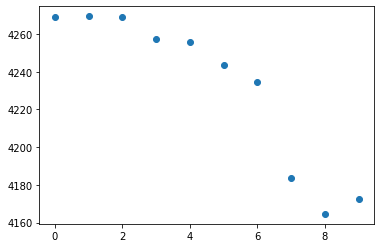

<function matplotlib.pyplot.show(*args, **kw)>

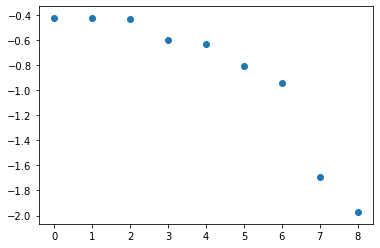

In [531]:
data = df_analisys_02.iloc[-10:,:]['Close'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_close_info_01.iloc[0,:][['ss1_close_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show


In [532]:
ls_ss1vars = ['ss1_close_' + str(x) for x in range(100,8,-1)]
ls_ss1vars

ls_ss1vars2 = ['ss1_close_' + str(x) for x in range(8,0,-1) ]
ls_ss1vars2

ls_slopevars = ['slope_close_' + str(x) for x in range(0,4) ]
ls_slopevars

['slope_close_0', 'slope_close_1', 'slope_close_2', 'slope_close_3']

In [533]:
#Assigns correct format to variable to apply transformations
df_close_info_01[ls_ss1vars] = df_close_info_01[ls_ss1vars].astype(float)
df_close_info_01[ls_ss1vars2] = df_close_info_01[ls_ss1vars2].astype(float)
df_close_info_01[ls_slopevars] = df_close_info_01[ls_slopevars].astype(float)

In [534]:
df_close_info_01 = df_close_info_01[df_close_info_01.notna().all(axis=1)]

df_close_info_01[ls_slopevars + ls_ss1vars2 + ls_ss1vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473 entries, 0 to 472
Columns: 104 entries, slope_close_0 to ss1_close_9
dtypes: float64(104)
memory usage: 388.0 KB


In [535]:
#Defines X vector to all process

X = df_close_info_01[ls_slopevars + ls_ss1vars2 + ls_ss1vars]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(473, 104)


In [536]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss1vars2),
                                     ("pca1", pca_pip, ls_ss1vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [537]:
Xtr.shape

(473, 15)

In [538]:
#Defines the df of all transformations

ls_ss1pcavars = ['ss1_close_c1','ss1_close_c2','ss1_close_c3']

df_close_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss1vars2 + ls_ss1pcavars)
print(df_close_info_tr_01.shape)
df_close_info_tr_01

(473, 15)


,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss1_close_8,ss1_close_7,ss1_close_6,ss1_close_5,ss1_close_4,ss1_close_3,ss1_close_2,ss1_close_1,ss1_close_c1,ss1_close_c2,ss1_close_c3
0,0.003629,0.058559,0.150079,0.142140,-1.689692,-0.940796,-0.804433,-0.626318,-0.601297,-0.430730,-0.421396,-0.423471,-7.541738,-0.157158,2.097353
1,0.089073,0.095229,0.216398,0.138782,-1.973149,-1.692083,-0.950487,-0.815453,-0.639074,-0.614297,-0.445392,-0.436150,-7.363405,-0.155918,2.041864
2,0.096076,0.120178,0.235749,0.126609,-1.858767,-1.975277,-1.696432,-0.960694,-0.826726,-0.651740,-0.627158,-0.459588,-7.199785,-0.181289,1.973720
3,0.098913,0.242614,0.204206,0.097213,-1.644020,-1.861171,-1.976665,-1.700253,-0.970937,-0.838138,-0.664680,-0.640312,-7.055811,-0.216138,1.945655
4,0.152118,0.346308,0.151666,0.060639,-1.509840,-1.652792,-1.868511,-1.983242,-1.708654,-0.984151,-0.852229,-0.679916,-6.932822,-0.272783,1.918832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.090065,0.007142,0.034934,0.011366,1.850144,1.822091,1.973205,2.059604,2.093728,1.932402,2.059293,2.112533,5.349939,2.382060,-5.685870
469,-0.017583,0.004593,0.029769,0.010056,1.965495,1.917643,1.888996,2.043314,2.131545,2.166393,2.001646,2.131228,5.163885,2.157424,-5.560469
470,-0.066491,0.035665,0.020249,0.011812,2.092338,2.035002,1.986015,1.956688,2.114667,2.204992,2.240666,2.072011,4.919715,1.989071,-5.266242
471,0.064408,0.077455,0.028945,0.019920,2.076710,2.159521,2.100903,2.050821,2.020838,2.182350,2.274695,2.311167,4.650902,1.835075,-4.887836


In [539]:
# Concat the Datetime to the transformed data

df_close_info_tr_01 = pd.concat([df_close_info_01['Datetime'],df_close_info_tr_01],axis=1)
df_close_info_tr_01

,Datetime,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss1_close_8,ss1_close_7,ss1_close_6,ss1_close_5,ss1_close_4,ss1_close_3,ss1_close_2,ss1_close_1,ss1_close_c1,ss1_close_c2,ss1_close_c3
0,2022-03-08 13:16:20,0.003629,0.058559,0.150079,0.142140,-1.689692,-0.940796,-0.804433,-0.626318,-0.601297,-0.430730,-0.421396,-0.423471,-7.541738,-0.157158,2.097353
1,2022-03-08 13:15:00,0.089073,0.095229,0.216398,0.138782,-1.973149,-1.692083,-0.950487,-0.815453,-0.639074,-0.614297,-0.445392,-0.436150,-7.363405,-0.155918,2.041864
2,2022-03-08 13:00:00,0.096076,0.120178,0.235749,0.126609,-1.858767,-1.975277,-1.696432,-0.960694,-0.826726,-0.651740,-0.627158,-0.459588,-7.199785,-0.181289,1.973720
3,2022-03-08 12:45:00,0.098913,0.242614,0.204206,0.097213,-1.644020,-1.861171,-1.976665,-1.700253,-0.970937,-0.838138,-0.664680,-0.640312,-7.055811,-0.216138,1.945655
4,2022-03-08 12:30:00,0.152118,0.346308,0.151666,0.060639,-1.509840,-1.652792,-1.868511,-1.983242,-1.708654,-0.984151,-0.852229,-0.679916,-6.932822,-0.272783,1.918832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2022-02-09 13:30:00,0.090065,0.007142,0.034934,0.011366,1.850144,1.822091,1.973205,2.059604,2.093728,1.932402,2.059293,2.112533,5.349939,2.382060,-5.685870
469,2022-02-09 13:15:00,-0.017583,0.004593,0.029769,0.010056,1.965495,1.917643,1.888996,2.043314,2.131545,2.166393,2.001646,2.131228,5.163885,2.157424,-5.560469
470,2022-02-09 13:00:00,-0.066491,0.035665,0.020249,0.011812,2.092338,2.035002,1.986015,1.956688,2.114667,2.204992,2.240666,2.072011,4.919715,1.989071,-5.266242
471,2022-02-09 12:45:00,0.064408,0.077455,0.028945,0.019920,2.076710,2.159521,2.100903,2.050821,2.020838,2.182350,2.274695,2.311167,4.650902,1.835075,-4.887836


In [540]:
pd.concat([df_close_info_01[['Datetime'] +ls_ss1vars2].iloc[0:1,:],
           df_close_info_01[['Datetime'] +ls_ss1vars2].iloc[0:1,:]],axis=0)

,Datetime,ss1_close_8,ss1_close_7,ss1_close_6,ss1_close_5,ss1_close_4,ss1_close_3,ss1_close_2,ss1_close_1
0,2022-03-08 13:16:20,-1.689692,-0.940796,-0.804433,-0.626318,-0.601297,-0.43073,-0.421396,-0.423471
0,2022-03-08 13:16:20,-1.689692,-0.940796,-0.804433,-0.626318,-0.601297,-0.43073,-0.421396,-0.423471


## MACD info

### Histogram

In [541]:
for c in df_analisys_02.columns.tolist():
    print(c)

Datetime
Open
High
Low
Close
Adj Close
Volume
date
body_size
abs_body_size
upper_tail_size
lower_tail_size
body_disposal
target_date
target_close
target_difference
target_date_diff
target_order
target_order_bin
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
diff_ewm50
diff_ewm200


In [542]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 100

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss1 = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss1_macdh_' + str(x) for x in range(len(X_ss1),0,-1) ]
    df_ssdata1 = pd.DataFrame(X_ss1.T,columns=ls_columns)
    ###############################################################################################

    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss1[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macdh_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macdh_info = pd.concat([df_ssdata1, df_linregcoefs],axis=1,sort=False)
    df_macdh_info['Datetime'] = Datetime
    
    if i == 0:
        df_macdh_info_01 = df_macdh_info.copy()
    else:
        df_macdh_info_01 = df_macdh_info_01.append(df_macdh_info,sort=False).copy()
        
df_macdh_info_01 = df_macdh_info_01.reset_index(drop=True)
df_macdh_info_01

,ss1_macdh_100,ss1_macdh_99,ss1_macdh_98,ss1_macdh_97,ss1_macdh_96,ss1_macdh_95,ss1_macdh_94,ss1_macdh_93,ss1_macdh_92,ss1_macdh_91,...,ss1_macdh_5,ss1_macdh_4,ss1_macdh_3,ss1_macdh_2,ss1_macdh_1,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,Datetime
0,0.082215,-0.104273,-0.140962,-0.179755,-0.342428,-0.106673,-0.042226,-0.134732,-0.395762,-0.812930,...,2.540483,2.845957,3.098323,3.136449,3.020192,-0.039065,0.124991,0.389514,0.353424,2022-03-08 13:16:20
1,0.396116,0.114209,-0.081358,-0.119834,-0.160516,-0.331109,-0.083875,-0.016290,-0.113301,-0.387039,...,2.076526,2.692159,3.012506,3.277159,3.317140,0.152317,0.306623,0.522870,0.369260,2022-03-08 13:15:00
2,0.555627,0.449368,0.150822,-0.056289,-0.097035,-0.140118,-0.320781,-0.058954,0.012620,-0.090117,...,1.413121,2.228966,2.880938,3.220193,3.500467,0.309765,0.516592,0.571257,0.355697,2022-03-08 13:00:00
3,0.897379,0.619709,0.506656,0.189020,-0.031333,-0.074685,-0.120523,-0.312737,-0.034169,0.041981,...,0.387352,1.532032,2.400043,3.093702,3.454650,0.527303,0.769626,0.539677,0.305410,2022-03-08 12:45:00
4,1.126405,0.976351,0.682164,0.562387,0.225857,-0.007604,-0.053534,-0.102099,-0.305746,-0.010609,...,0.084107,0.435986,1.648755,2.568397,3.303317,0.827281,0.857083,0.464564,0.229749,2022-03-08 12:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.738626,0.914638,1.485699,-0.708535,-0.953177,-1.219438,-0.205228,NaN,NaN,2022-02-03 14:45:00
568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.993922,0.688115,1.269115,-0.963308,-0.825712,NaN,NaN,NaN,2022-02-03 14:30:00
569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.370334,0.382449,0.987885,1.179110,NaN,NaN,NaN,2022-02-03 14:15:00
570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2022-02-03 14:00:00


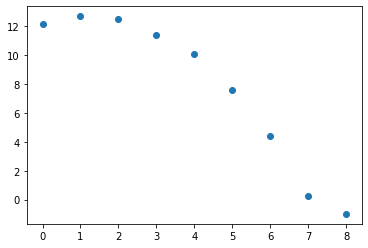

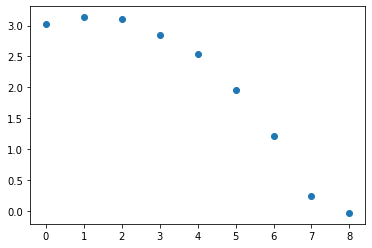

In [543]:
data = df_analisys_02.iloc[-9:,:]['MACDh_12_26_9'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_macdh_info_01.iloc[0,:][['ss1_macdh_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

In [544]:
# Create variable names lists to naming columns

ls_ss1vars = ['ss1_macdh_' + str(x) for x in range(100,8,-1)]
ls_ss1vars

ls_ss1vars2 = ['ss1_macdh_' + str(x) for x in range(8,0,-1) ]
ls_ss1vars2

ls_slopevars = ['slope_macdh_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macdh_0', 'slope_macdh_1', 'slope_macdh_2', 'slope_macdh_3']

In [545]:
#Assigns correct format to variable to apply transformations
df_macdh_info_01[ls_ss1vars2] = df_macdh_info_01[ls_ss1vars2].astype(float)
df_macdh_info_01[ls_ss1vars] = df_macdh_info_01[ls_ss1vars].astype(float)
df_macdh_info_01[ls_slopevars] = df_macdh_info_01[ls_slopevars].astype(float)

In [546]:
df_macdh_info_01 = df_macdh_info_01[df_macdh_info_01.notna().all(axis=1)]

df_macdh_info_01[ls_slopevars + ls_ss1vars2 + ls_ss1vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473 entries, 0 to 472
Columns: 104 entries, slope_macdh_0 to ss1_macdh_9
dtypes: float64(104)
memory usage: 388.0 KB


In [547]:
#Defines X vector to all process

X = df_macdh_info_01[ls_slopevars + ls_ss1vars2 + ls_ss1vars]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(473, 104)


In [548]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss1vars2),
                                     ("pca1", pca_pip, ls_ss1vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [549]:
Xtr.shape

(473, 15)

In [550]:
#Defines the df of all transformations

ls_ss1pcavars = ['ss1_macdh_c1','ss1_macdh_c2','ss1_macdh_c3']

df_macdh_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss1vars2 + ls_ss1pcavars)
print(df_macdh_info_tr_01.shape)
df_macdh_info_tr_01

(473, 15)


,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss1_macdh_8,ss1_macdh_7,ss1_macdh_6,ss1_macdh_5,ss1_macdh_4,ss1_macdh_3,ss1_macdh_2,ss1_macdh_1,ss1_macdh_c1,ss1_macdh_c2,ss1_macdh_c3
0,-0.039065,0.124991,0.389514,0.353424,0.250066,1.218822,1.953431,2.540483,2.845957,3.098323,3.136449,3.020192,1.317753,-1.777788,0.851696
1,0.152317,0.306623,0.522870,0.369260,-0.004533,0.290232,1.306153,2.076526,2.692159,3.012506,3.277159,3.317140,1.255489,-1.998271,0.653164
2,0.309765,0.516592,0.571257,0.355697,0.134322,0.025071,0.337235,1.413121,2.228966,2.880938,3.220193,3.500467,1.180966,-2.247076,0.375889
3,0.527303,0.769626,0.539677,0.305410,0.234285,0.171465,0.055229,0.387352,1.532032,2.400043,3.093702,3.454650,1.060807,-2.524685,-0.008962
4,0.827281,0.857083,0.464564,0.229749,0.035594,0.273814,0.207257,0.084107,0.435986,1.648755,2.568397,3.303317,0.864183,-2.807876,-0.487045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-0.085585,-0.140150,-0.163456,-0.238331,0.452306,0.109386,-0.078152,-0.203810,-0.320566,-0.560630,-0.666081,-0.731800,-3.522850,0.679908,4.188154
469,-0.172603,-0.153130,-0.200718,-0.245598,0.819358,0.453039,0.110427,-0.076943,-0.202488,-0.319139,-0.558988,-0.664345,-3.187328,0.990580,4.427830
470,-0.178354,-0.158195,-0.238063,-0.238482,1.174929,0.818891,0.452359,0.109547,-0.077932,-0.203550,-0.320269,-0.560258,-2.821238,1.269095,4.569792
471,-0.121109,-0.185744,-0.268053,-0.212365,1.480096,1.175171,0.819309,0.452959,0.110316,-0.077071,-0.202627,-0.319288,-2.396623,1.523465,4.646466


In [551]:
# Concat the Datetime to the transformed data

df_macdh_info_tr_01 = pd.concat([df_macdh_info_01['Datetime'],df_macdh_info_tr_01],axis=1)
df_macdh_info_tr_01

,Datetime,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss1_macdh_8,ss1_macdh_7,ss1_macdh_6,ss1_macdh_5,ss1_macdh_4,ss1_macdh_3,ss1_macdh_2,ss1_macdh_1,ss1_macdh_c1,ss1_macdh_c2,ss1_macdh_c3
0,2022-03-08 13:16:20,-0.039065,0.124991,0.389514,0.353424,0.250066,1.218822,1.953431,2.540483,2.845957,3.098323,3.136449,3.020192,1.317753,-1.777788,0.851696
1,2022-03-08 13:15:00,0.152317,0.306623,0.522870,0.369260,-0.004533,0.290232,1.306153,2.076526,2.692159,3.012506,3.277159,3.317140,1.255489,-1.998271,0.653164
2,2022-03-08 13:00:00,0.309765,0.516592,0.571257,0.355697,0.134322,0.025071,0.337235,1.413121,2.228966,2.880938,3.220193,3.500467,1.180966,-2.247076,0.375889
3,2022-03-08 12:45:00,0.527303,0.769626,0.539677,0.305410,0.234285,0.171465,0.055229,0.387352,1.532032,2.400043,3.093702,3.454650,1.060807,-2.524685,-0.008962
4,2022-03-08 12:30:00,0.827281,0.857083,0.464564,0.229749,0.035594,0.273814,0.207257,0.084107,0.435986,1.648755,2.568397,3.303317,0.864183,-2.807876,-0.487045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2022-02-09 13:30:00,-0.085585,-0.140150,-0.163456,-0.238331,0.452306,0.109386,-0.078152,-0.203810,-0.320566,-0.560630,-0.666081,-0.731800,-3.522850,0.679908,4.188154
469,2022-02-09 13:15:00,-0.172603,-0.153130,-0.200718,-0.245598,0.819358,0.453039,0.110427,-0.076943,-0.202488,-0.319139,-0.558988,-0.664345,-3.187328,0.990580,4.427830
470,2022-02-09 13:00:00,-0.178354,-0.158195,-0.238063,-0.238482,1.174929,0.818891,0.452359,0.109547,-0.077932,-0.203550,-0.320269,-0.560258,-2.821238,1.269095,4.569792
471,2022-02-09 12:45:00,-0.121109,-0.185744,-0.268053,-0.212365,1.480096,1.175171,0.819309,0.452959,0.110316,-0.077071,-0.202627,-0.319288,-2.396623,1.523465,4.646466


In [552]:
pd.concat([df_macdh_info_tr_01[['Datetime'] +ls_ss1vars2].iloc[0:1,:],
           df_macdh_info_tr_01[['Datetime'] +ls_ss1vars2].iloc[0:1,:]],axis=0)

,Datetime,ss1_macdh_8,ss1_macdh_7,ss1_macdh_6,ss1_macdh_5,ss1_macdh_4,ss1_macdh_3,ss1_macdh_2,ss1_macdh_1
0,2022-03-08 13:16:20,0.250066,1.218822,1.953431,2.540483,2.845957,3.098323,3.136449,3.020192
0,2022-03-08 13:16:20,0.250066,1.218822,1.953431,2.540483,2.845957,3.098323,3.136449,3.020192


# VOLUME DATA

In [553]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys_02)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 100

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['Volume']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Volume']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]
        
    if X.loc[max(X.index)][0] == 0:
        X.loc[max(X.index)][0] = X.loc[max(X.index)-1][0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss1 = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss1_vols_' + str(x) for x in range(len(X_ss1),0,-1) ]
    df_ssdata1 = pd.DataFrame(X_ss1.T,columns=ls_columns)
    ###############################################################################################

    
    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss1[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_vols_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_vols_info = pd.concat([df_ssdata1,df_linregcoefs],axis=1,sort=False)
    df_vols_info['Datetime'] = Datetime
    
    if i == 0:
        df_vols_info_01 = df_vols_info.copy()
    else:
        df_vols_info_01 = df_vols_info_01.append(df_vols_info,sort=False).copy()
        
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
df_vols_info_01

,ss1_vols_100,ss1_vols_99,ss1_vols_98,ss1_vols_97,ss1_vols_96,ss1_vols_95,ss1_vols_94,ss1_vols_93,ss1_vols_92,ss1_vols_91,...,ss1_vols_5,ss1_vols_4,ss1_vols_3,ss1_vols_2,ss1_vols_1,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,Datetime
0,-0.561114,-0.514115,-0.365273,0.210097,3.819856,-0.097794,0.740367,0.089919,-0.132168,-0.233706,...,0.602830,0.095215,0.071199,-1.770338,-1.770338,-0.920769,-0.661189,-0.279830,-0.117246,2022-03-08 13:16:20
1,-0.787797,-0.578580,-0.530968,-0.380188,0.202676,3.859451,-0.109225,0.739852,0.080932,-0.144047,...,1.017619,0.600524,0.086298,0.061969,-1.803554,-0.944926,-0.618090,-0.131914,-0.080249,2022-03-08 13:15:00
2,-0.690026,-0.810649,-0.598420,-0.550122,-0.397172,0.194084,3.903503,-0.122308,0.738993,0.070587,...,0.189915,1.020759,0.597660,0.076030,0.051351,-0.273154,-0.122186,0.062784,-0.033137,2022-03-08 13:00:00
3,-0.814990,-0.678968,-0.799186,-0.587668,-0.539532,-0.387093,0.202184,3.899187,-0.113149,0.745269,...,-0.321150,0.198029,1.026092,0.604409,0.084525,-0.470783,0.121773,0.078381,-0.045763,2022-03-08 12:45:00
4,-0.826754,-0.802999,-0.667442,-0.787249,-0.576455,-0.528484,-0.376566,0.210694,3.895045,-0.103560,...,-0.053008,-0.310849,0.206553,1.031782,0.611542,0.202495,0.267173,0.075427,-0.077256,2022-03-08 12:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.533407,-0.348939,-0.221133,1.416220,0.687260,0.454196,0.620649,NaN,NaN,2022-02-03 14:45:00
568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.296814,-0.168698,-0.046972,1.512484,0.840591,NaN,NaN,NaN,2022-02-03 14:30:00
569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.408688,0.596179,0.812509,1.110598,NaN,NaN,NaN,2022-02-03 14:15:00
570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2022-02-03 14:00:00


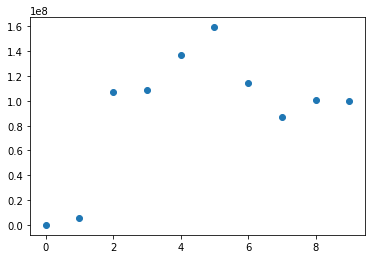

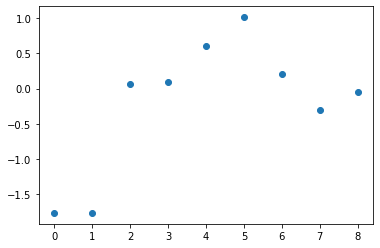

ss1_vols_1   -1.770338
ss1_vols_2   -1.770338
ss1_vols_3    0.071199
ss1_vols_4    0.095215
ss1_vols_5     0.60283
ss1_vols_6    1.014562
ss1_vols_7     0.20604
ss1_vols_8   -0.300886
ss1_vols_9   -0.048265
Name: 0, dtype: object

In [554]:
data = df_analisys_02.iloc[-10:,:]['Volume'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_vols_info_01.iloc[0,:][['ss1_vols_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

data

In [555]:
# Create variable names lists to naming columns

ls_ss1vars = ['ss1_vols_' + str(x) for x in range(100,8,-1)]
ls_ss1vars

ls_ss1vars2 = ['ss1_vols_' + str(x) for x in range(8,0,-1) ]
ls_ss1vars2

ls_slopevars = ['slope_vols_' + str(x) for x in range(0,4) ]
ls_slopevars

['slope_vols_0', 'slope_vols_1', 'slope_vols_2', 'slope_vols_3']

In [556]:
#Assigns correct format to variable to apply transformations

df_vols_info_01[ls_ss1vars2] = df_vols_info_01[ls_ss1vars2].astype(float)
df_vols_info_01[ls_ss1vars] = df_vols_info_01[ls_ss1vars].astype(float)
df_vols_info_01[ls_slopevars] = df_vols_info_01[ls_slopevars].astype(float)

In [557]:
df_vols_info_01 = df_vols_info_01[df_vols_info_01.notna().all(axis=1)]
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
print(df_vols_info_01.shape)

df_vols_info_01[ls_slopevars + ls_ss1vars2 + ls_ss1vars].info()



(473, 105)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Columns: 104 entries, slope_vols_0 to ss1_vols_9
dtypes: float64(104)
memory usage: 384.4 KB


In [558]:
#Defines X vector to all process

X = df_vols_info_01[ls_slopevars + ls_ss1vars2 + ls_ss1vars]
print(X.shape)


(473, 104)


In [559]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss1vars2),
                                     ("pca1", pca_pip, ls_ss1vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [560]:
Xtr.shape

(473, 15)

In [561]:
#Defines the df of all transformations

ls_ss1pcavars = ['ss1_vols_c1','ss1_vols_c2','ss1_vols_c3']

df_vols_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss1vars2 + ls_ss1pcavars)
print(df_vols_info_tr_01.shape)
df_vols_info_tr_01

(473, 15)


,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,ss1_vols_8,ss1_vols_7,ss1_vols_6,ss1_vols_5,ss1_vols_4,ss1_vols_3,ss1_vols_2,ss1_vols_1,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3
0,-0.920769,-0.661189,-0.279830,-0.117246,-0.300886,0.206040,1.014562,0.602830,0.095215,0.071199,-1.770338,-1.770338,-0.659698,5.585649,-2.728035
1,-0.944926,-0.618090,-0.131914,-0.080249,-0.059051,-0.314963,0.198566,1.017619,0.600524,0.086298,0.061969,-1.803554,-2.134645,5.336622,-3.781471
2,-0.273154,-0.122186,0.062784,-0.033137,-0.080047,-0.071411,-0.331007,0.189915,1.020759,0.597660,0.076030,0.051351,-3.510698,4.721517,-3.669638
3,-0.470783,0.121773,0.078381,-0.045763,0.167081,-0.071030,-0.062423,-0.321150,0.198029,1.026092,0.604409,0.084525,-4.604366,3.717623,-2.376855
4,0.202495,0.267173,0.075427,-0.077256,0.395984,0.175712,-0.061585,-0.053008,-0.310849,0.206553,1.031782,0.611542,-5.395329,2.484974,-0.335242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,0.000011,-0.036853,-0.027617,-0.058236,-0.457765,-0.537724,-0.579986,-0.483254,-0.626796,-0.631616,-0.698646,-0.631594,-0.237262,5.966005,-2.671950
469,-0.035995,-0.038644,-0.043383,-0.071156,-0.333539,-0.463956,-0.544072,-0.586417,-0.489495,-0.633318,-0.638148,-0.705309,-1.724626,5.748813,-3.635176
470,-0.074434,-0.023539,-0.034431,-0.083622,-0.459835,-0.336502,-0.467107,-0.547338,-0.589744,-0.492682,-0.636714,-0.641550,-3.173009,5.137651,-3.485092
471,-0.023505,-0.028481,-0.066379,-0.106130,0.014167,-0.461771,-0.338330,-0.469049,-0.549350,-0.591793,-0.494646,-0.638803,-4.359501,4.200183,-2.265555


In [562]:
# Concat the Datetime to the transformed data

df_vols_info_tr_01 = pd.concat([df_vols_info_01['Datetime'],df_vols_info_tr_01],axis=1)
df_vols_info_tr_01

,Datetime,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,ss1_vols_8,ss1_vols_7,ss1_vols_6,ss1_vols_5,ss1_vols_4,ss1_vols_3,ss1_vols_2,ss1_vols_1,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3
0,2022-03-08 13:16:20,-0.920769,-0.661189,-0.279830,-0.117246,-0.300886,0.206040,1.014562,0.602830,0.095215,0.071199,-1.770338,-1.770338,-0.659698,5.585649,-2.728035
1,2022-03-08 13:15:00,-0.944926,-0.618090,-0.131914,-0.080249,-0.059051,-0.314963,0.198566,1.017619,0.600524,0.086298,0.061969,-1.803554,-2.134645,5.336622,-3.781471
2,2022-03-08 13:00:00,-0.273154,-0.122186,0.062784,-0.033137,-0.080047,-0.071411,-0.331007,0.189915,1.020759,0.597660,0.076030,0.051351,-3.510698,4.721517,-3.669638
3,2022-03-08 12:45:00,-0.470783,0.121773,0.078381,-0.045763,0.167081,-0.071030,-0.062423,-0.321150,0.198029,1.026092,0.604409,0.084525,-4.604366,3.717623,-2.376855
4,2022-03-08 12:30:00,0.202495,0.267173,0.075427,-0.077256,0.395984,0.175712,-0.061585,-0.053008,-0.310849,0.206553,1.031782,0.611542,-5.395329,2.484974,-0.335242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2022-02-09 13:30:00,0.000011,-0.036853,-0.027617,-0.058236,-0.457765,-0.537724,-0.579986,-0.483254,-0.626796,-0.631616,-0.698646,-0.631594,-0.237262,5.966005,-2.671950
469,2022-02-09 13:15:00,-0.035995,-0.038644,-0.043383,-0.071156,-0.333539,-0.463956,-0.544072,-0.586417,-0.489495,-0.633318,-0.638148,-0.705309,-1.724626,5.748813,-3.635176
470,2022-02-09 13:00:00,-0.074434,-0.023539,-0.034431,-0.083622,-0.459835,-0.336502,-0.467107,-0.547338,-0.589744,-0.492682,-0.636714,-0.641550,-3.173009,5.137651,-3.485092
471,2022-02-09 12:45:00,-0.023505,-0.028481,-0.066379,-0.106130,0.014167,-0.461771,-0.338330,-0.469049,-0.549350,-0.591793,-0.494646,-0.638803,-4.359501,4.200183,-2.265555


In [563]:
pd.concat([df_vols_info_tr_01[['Datetime'] +ls_ss1vars2].iloc[0:1,:],
           df_vols_info_01[['Datetime'] +ls_ss1vars2].iloc[0:1,:]],axis=0)

,Datetime,ss1_vols_8,ss1_vols_7,ss1_vols_6,ss1_vols_5,ss1_vols_4,ss1_vols_3,ss1_vols_2,ss1_vols_1
0,2022-03-08 13:16:20,-0.300886,0.20604,1.014562,0.60283,0.095215,0.071199,-1.770338,-1.770338
0,2022-03-08 13:16:20,-0.300886,0.20604,1.014562,0.60283,0.095215,0.071199,-1.770338,-1.770338


# Attaches target variable to the df with transformations

In [564]:
ls_tgcols = ['date','Datetime','Close','target_order','target_order_bin','target_close','target_difference','target_date','target_date_diff']


df_transformations_100 = pd.merge(df_close_info_tr_01,
                           df_macdh_info_tr_01,
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_transformations_100 = pd.merge(df_transformations_100,
                           df_vols_info_tr_01,
                           on = ['Datetime'],
                           how='inner'
                         ).copy()

df_analisys_100 = pd.merge(df_transformations_100,
                           df_analisys_02[ls_tgcols],
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_analisys_100 = df_analisys_100.sort_values(['Datetime']).reset_index(drop=True)

print(df_analisys_100.shape)

df_analisys_100


(473, 54)


,Datetime,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss1_close_8,ss1_close_7,ss1_close_6,ss1_close_5,ss1_close_4,...,ss1_vols_c2,ss1_vols_c3,date,Close,target_order,target_order_bin,target_close,target_difference,target_date,target_date_diff
0,2022-02-09 12:30:00,0.130490,0.049256,-0.004145,0.013214,2.420307,2.157907,2.243042,2.182779,2.131291,...,2.964355,-0.295553,2022-02-09,4577.859863,SELL2,0,4551.689941,-26.0,2022-02-10 09:30:00,1260.0
1,2022-02-09 12:45:00,0.064408,0.077455,0.028945,0.019920,2.076710,2.159521,2.100903,2.050821,2.020838,...,4.200183,-2.265555,2022-02-09,4578.930176,SELL2,0,4551.689941,-27.0,2022-02-10 09:30:00,1245.0
2,2022-02-09 13:00:00,-0.066491,0.035665,0.020249,0.011812,2.092338,2.035002,1.986015,1.956688,2.114667,...,5.137651,-3.485092,2022-02-09,4573.870117,SELL2,0,4551.689941,-22.0,2022-02-10 09:30:00,1230.0
3,2022-02-09 13:15:00,-0.017583,0.004593,0.029769,0.010056,1.965495,1.917643,1.888996,2.043314,2.131545,...,5.748813,-3.635176,2022-02-09,4577.850098,SELL2,0,4551.689941,-26.0,2022-02-10 09:30:00,1215.0
4,2022-02-09 13:30:00,0.090065,0.007142,0.034934,0.011366,1.850144,1.822091,1.973205,2.059604,2.093728,...,5.966005,-2.671950,2022-02-09,4579.520020,SELL2,0,4551.689941,-28.0,2022-02-10 09:30:00,1200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2022-03-08 12:30:00,0.152118,0.346308,0.151666,0.060639,-1.509840,-1.652792,-1.868511,-1.983242,-1.708654,...,2.484974,-0.335242,2022-03-08,4255.589844,NULL,0,NaN,NaN,NaT,NaN
469,2022-03-08 12:45:00,0.098913,0.242614,0.204206,0.097213,-1.644020,-1.861171,-1.976665,-1.700253,-0.970937,...,3.717623,-2.376855,2022-03-08,4257.279785,NULL,0,NaN,NaN,NaT,NaN
470,2022-03-08 13:00:00,0.096076,0.120178,0.235749,0.126609,-1.858767,-1.975277,-1.696432,-0.960694,-0.826726,...,4.721517,-3.669638,2022-03-08,4268.799805,NULL,0,NaN,NaN,NaT,NaN
471,2022-03-08 13:15:00,0.089073,0.095229,0.216398,0.138782,-1.973149,-1.692083,-0.950487,-0.815453,-0.639074,...,5.336622,-3.781471,2022-03-08,4269.430176,NULL,0,NaN,NaN,NaT,NaN


In [565]:
print(min(df_analisys_100['Datetime']))
print(max(df_analisys_100['Datetime']))

2022-02-09 12:30:00
2022-03-08 13:16:20


In [566]:
print(df_analisys_100['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
2    BUY           109
3   BUY2            57
4   NULL             5
1   SELL           143
0  SELL2           159


In [567]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys_100.to_pickle(DIR_OUTPUTS + 'df_spx500_15m_s1' + '.pkl')
print(df_analisys_100.shape)
print(dt.datetime.now())

(473, 54)
2022-03-08 13:16:47.750961
